### In this notebook, we would look at regression analysis using TensorFlow. We will build a model to predict the value of amplitude of a noise transient based on it's signal to noise ratio (SNR). Noise tranisents are short duration glitches that adversely impact the sensitivity of Advanced Laser Interferometer Gravitational Observatory or aLIGO in short. These detectors are located in Hanford, Washington and Livingston, Louisiana in USA and there is more information about them here https://www.ligo.org. And more information about these noise transients can be found in this publication https://arxiv.org/abs/2101.11673
### Ampitude and SNR are two of the several other characteristics that define these transients and are related by the following equation


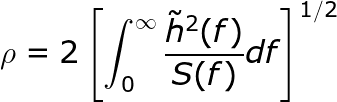

In [1]:
from IPython.display import Image
Image(filename='files/snr_amp.gif')

### $\rho$ here is the SNR, h(f) is the amplitude and S(f) is the power spectral density.  The amplitude of the transient is a more absolute measure of its energy, whereas SNR gives a more relative meaning to the noise transient. What is more important with respect to this project is that the two quantities are proportional to each other in the frequency region S(f) does not vary too much. We will import noise transient data in a csv file and look at these two quantities before building a tensorflow model to predict amplitude given an SNR. Since these values are continuous, the problem is based on regression.

In [2]:
import scipy
import os

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


import numpy as np
import pandas as pd

2.4.1


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
#plt.style.use('fivethirtyeight')

In [6]:
from files import functions

### Importing the data

In [7]:
df = pd.read_csv('files/noisy_data.csv')

In [8]:
df.describe()

,snr,amplitude,peakFreq
count,115623.000000,1.156230e+05,115623.000000
mean,65.634008,4.153996e-21,171.821001
std,364.991394,1.886000e-19,407.257590
min,7.500000,1.870000e-23,10.047000
25%,8.481000,8.920000e-23,24.264000
50%,10.370000,1.890000e-22,32.268000
75%,17.531500,4.510000e-22,47.681500
max,18300.936000,6.250000e-17,2046.281000


### These noise events, also known as glitches, can be defined as short duration bursts of energy which are caused by known or unkonwn environmental or electronic sources. These glitches are annotated with time, signal to noise ratio aka SNR, frequency, duration and other characterisitics. So what do these triggers really look like, in time-series they are a spike in the amplitude while the time-frequency spectrograms shows the morphology of the noise and in what frequency band the noise is dominant. Lets look at both the time-series as well as time-frequency spectrogram for two triggers with SNR of 15 and 1200 respectively.

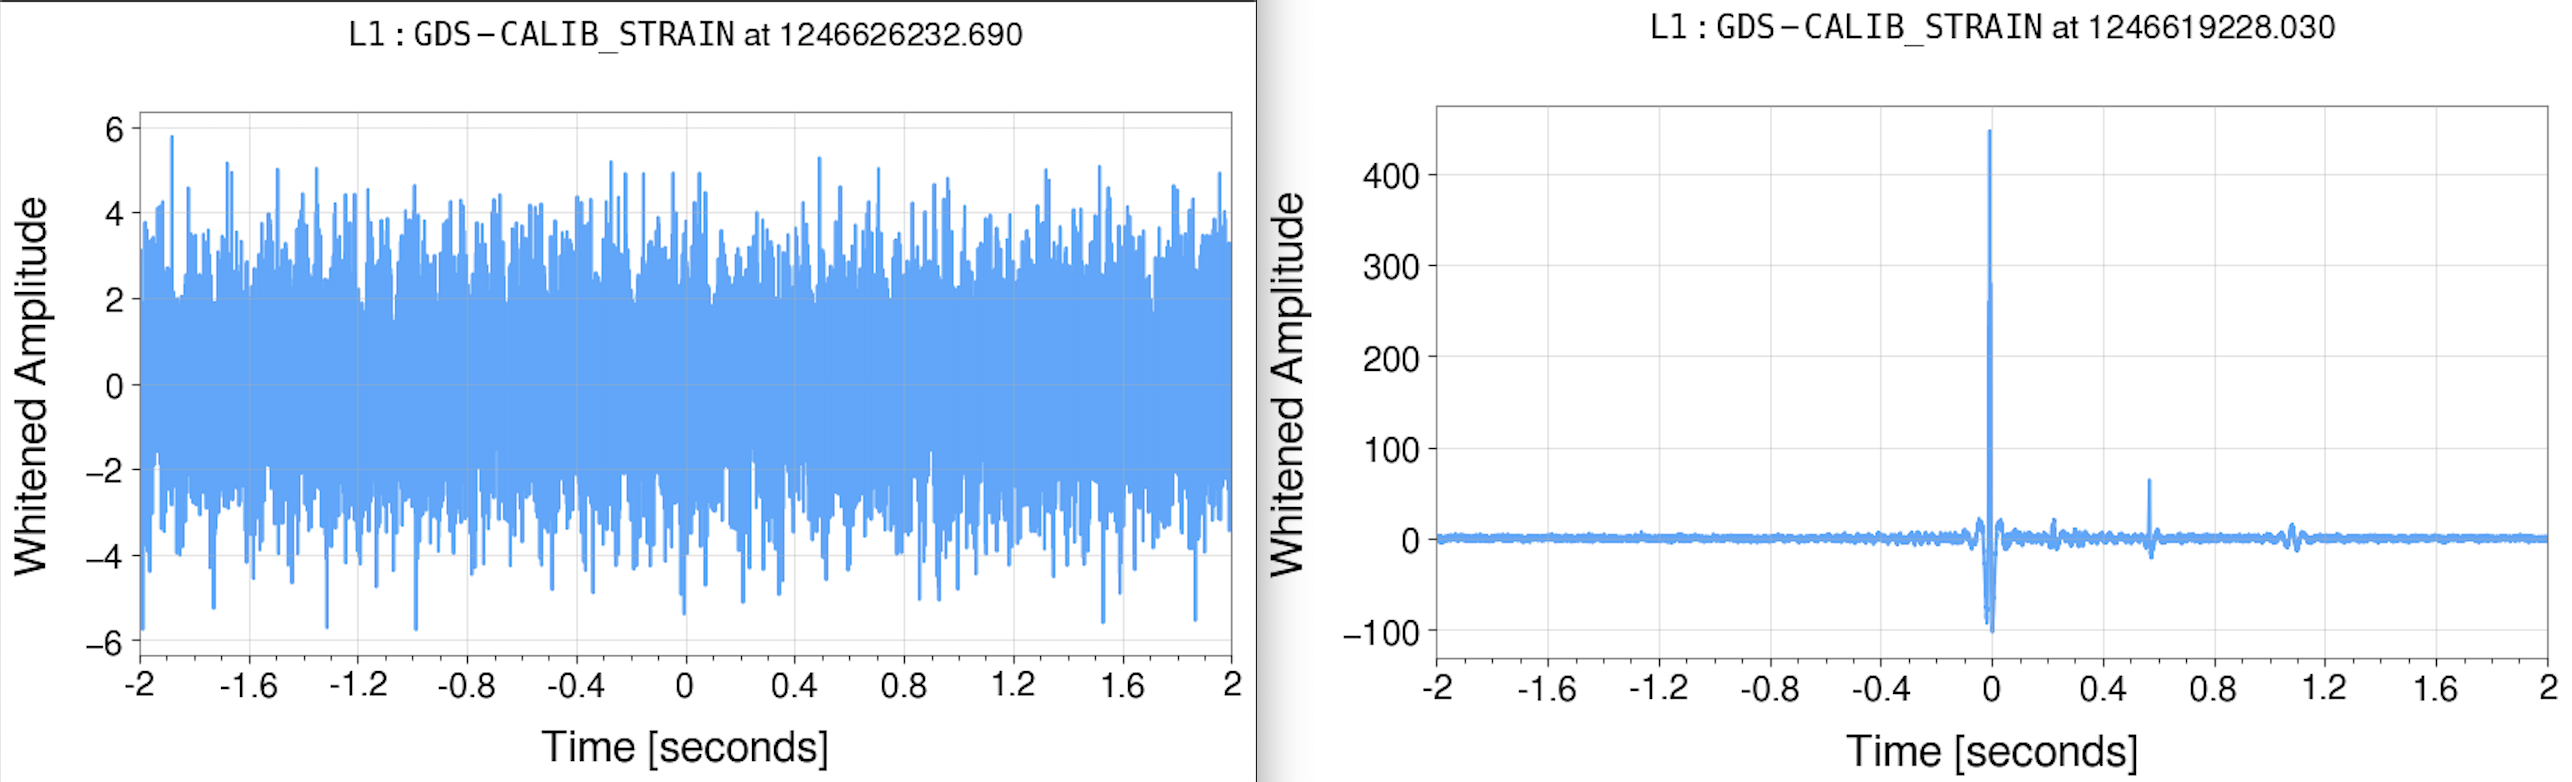

In [9]:
Image(filename='files/snr15_1200ts.png')

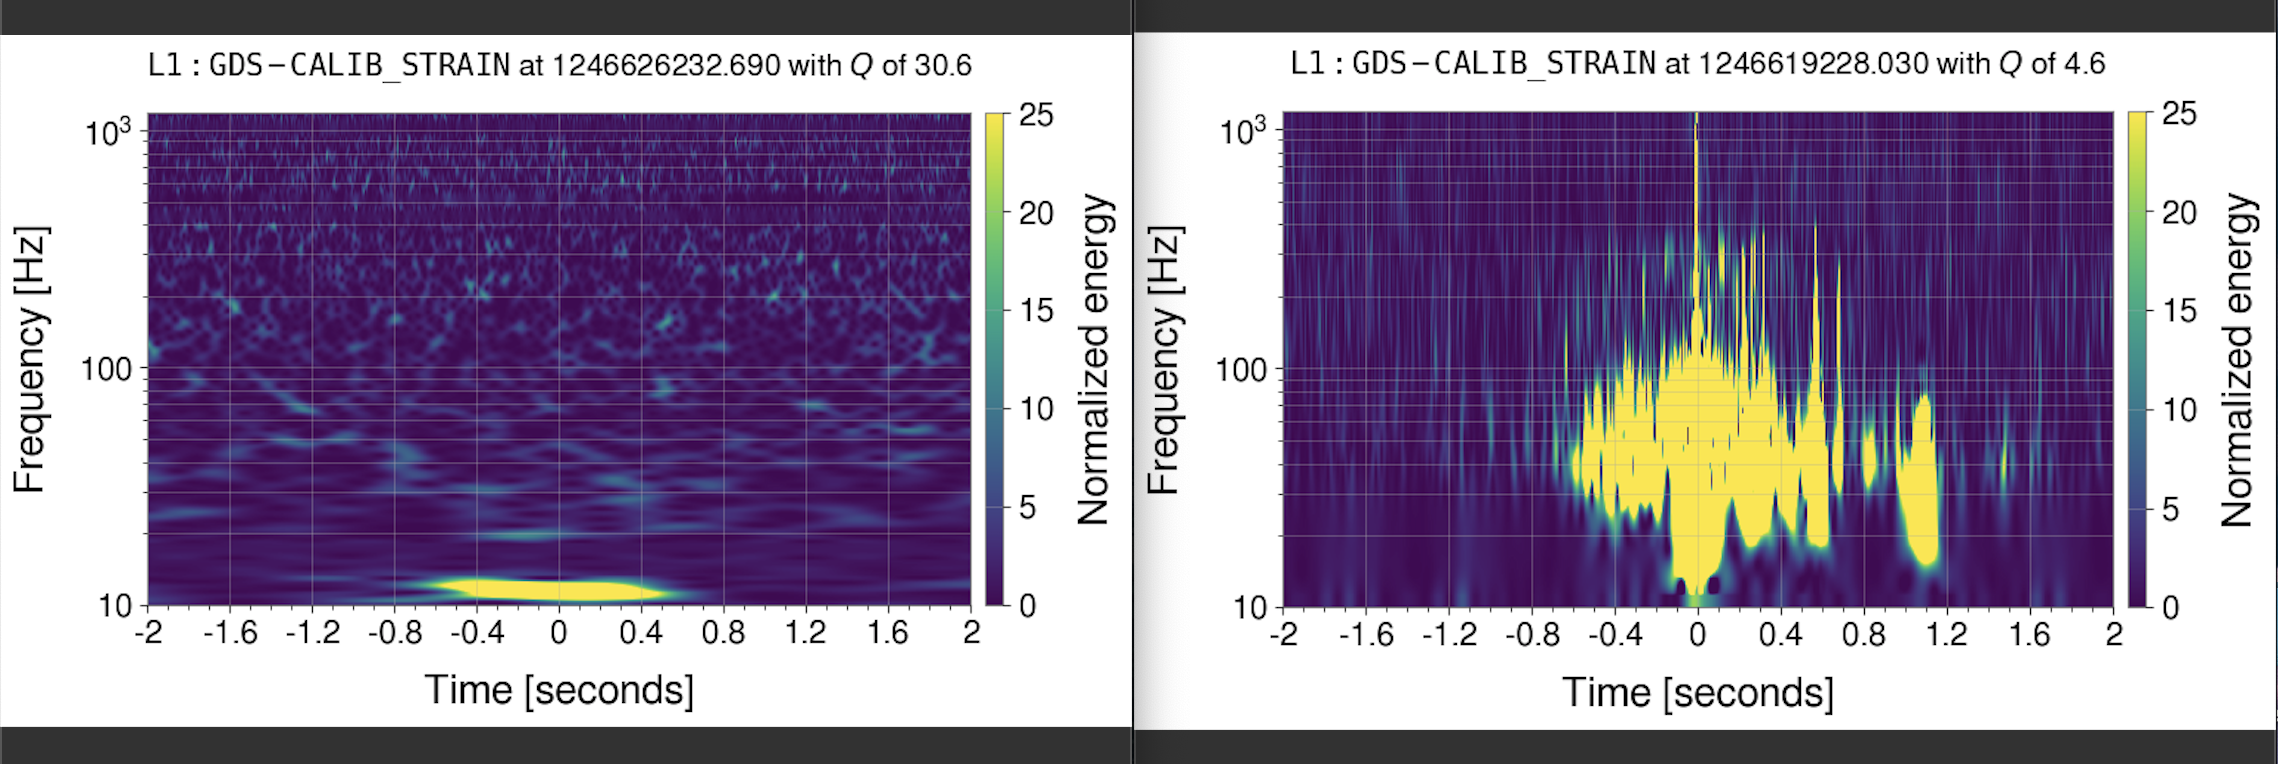

In [10]:
### same triggers shown in time-frequency plane
Image(filename='files/snr15_1000os.png')

### We can see in both the images, the second trigger is louder. 

### Next let's look at the Amplitude and SNR of these noise transients in a scatter plot to observe their dependence on each other

<Figure size 864x576 with 0 Axes>

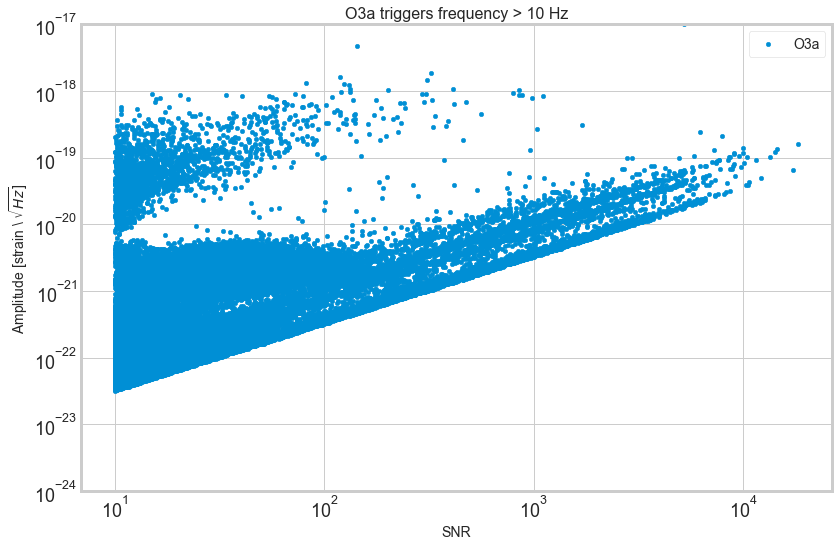

In [11]:
functions.plotampsnr(df,10,10)

### We see two blobs here. for the upper blob, the SNR is low even for high Amplitude values. And that's because those transients belong to lower frequency region where the sensitivity is low (S(f) is high). Let's now plot the same scatter plot but with frequency above 40 Hz.

<Figure size 864x576 with 0 Axes>

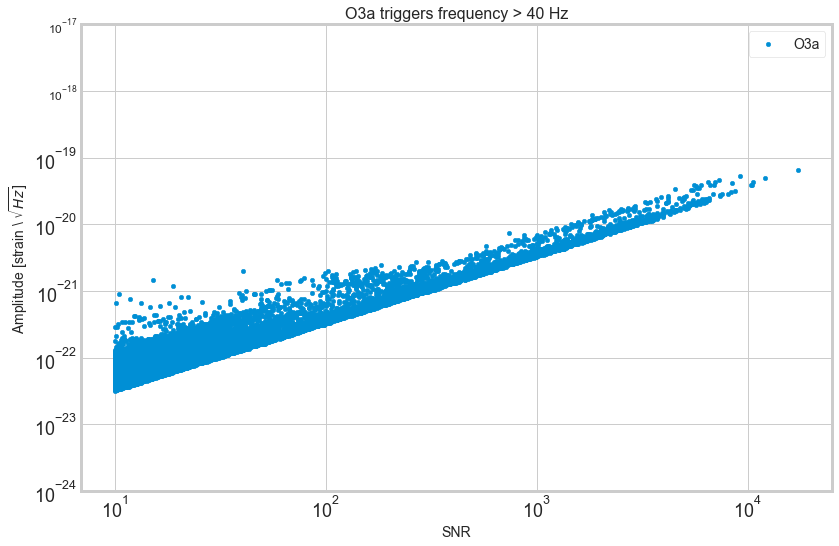

In [12]:
functions.plotampsnr(df,40,10)

### This looks much better. We will use the data with frequencies above 40 Hz.

In [13]:
df = df[df.peakFreq>=40]
df = df.reset_index(drop=True)

In [14]:
df.head()

,snr,amplitude,peakFreq
0,178.658,6.700000e-22,115.113
1,41.123,2.610000e-22,49.208
2,234.688,8.690000e-22,115.113
3,9.240,6.360000e-23,1270.186
4,8.727,5.270000e-23,47.124


### Next, let's separate the data into training and testing

In [15]:
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)

In [16]:
train_df.head()

,snr,amplitude,peakFreq
9857,8.484,4.770000e-23,49.208
20938,9.308,4.930000e-23,58.396
7657,15.198,9.620000e-23,49.208
13365,8.352,5.160000e-23,49.208
1442,9.610,5.770000e-23,47.183


In [17]:
test_df.head()

,snr,amplitude,peakFreq
10,7.981,4.840000e-23,1050.420
13,7.627,3.890000e-23,68.992
19,8.450,5.290000e-23,54.919
28,27.652,2.090000e-22,53.554
40,12.469,9.090000e-23,49.208


### Standardizing the data

In [18]:
def standarize(element,x,y):
    c = (element - x)/y
    return c

In [19]:
for i in train_df.columns:
    train_df[i] = train_df[i].apply(standarize, x = np.mean(train_df[i]), y = np.std(train_df[i]))
    test_df[i] = test_df[i].apply(standarize, x = np.mean(test_df[i]), y = np.std(test_df[i]))

### Separating the training and testing labels

In [20]:
train_label = train_df.pop('amplitude')
test_label = test_df.pop('amplitude')

### Okay, now we have training data, testing data and we have also separated the training and testing labels. Next we will build a model

In [101]:
train_df.keys()

Index(['snr', 'peakFreq'], dtype='object')

In [110]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='tanh', input_shape=[len(train_df.keys())]),
    layers.Dense(1)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.01)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse','mae'])
    return model

### This sequential model  has two layers, an input and an output layer, the input layer has 32 units/nodes and the activation function is tanh, the optimizer used is RMSprop with a learning rate of 0.01. And the loss function is mean squared error. 

In [111]:
model = build_model()

In [112]:
### Let's run it for 100 epochs with a validation split of 20%

In [113]:
n_epochs = 100

history = model.fit(
  train_df, train_label,
  epochs=n_epochs, validation_split = 0.2, verbose=0)

In [114]:
### Saving the training and validation loss as well as the mean squared error in a dataframe

In [115]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
95,0.042141,0.042141,0.086049,0.021620,0.021620,0.046437,95
96,0.045161,0.045161,0.084998,0.028380,0.028380,0.058702,96
97,0.043429,0.043429,0.085526,0.056218,0.056218,0.073671,97
98,0.043273,0.043273,0.089119,0.054073,0.054073,0.088396,98
99,0.042277,0.042277,0.087047,0.041767,0.041767,0.064241,99


In [116]:
hist.head()

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
0,0.150757,0.150757,0.130059,0.088740,0.088740,0.083186,0
1,0.146041,0.146041,0.129148,0.122841,0.122841,0.224772,1
2,0.145022,0.145022,0.127919,0.060977,0.060977,0.053006,2
3,0.139177,0.139177,0.125895,0.108398,0.108398,0.141613,3
4,0.132515,0.132515,0.124078,0.097433,0.097433,0.186663,4


### Plotting the Loss for training and Validation

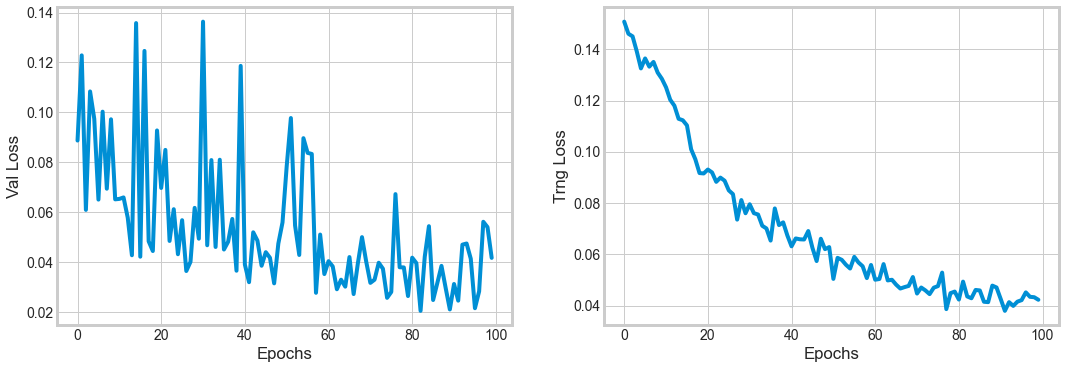

In [121]:
fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax1.plot(hist['val_loss'])
ax1.set_ylabel("Val Loss")
ax1.set_xlabel("Epochs")
ax2.plot(hist['loss'])
ax2.set_ylabel("Trng Loss")
ax2.set_xlabel("Epochs")
plt.show()

### Plotting the mean squared error for training and Validation

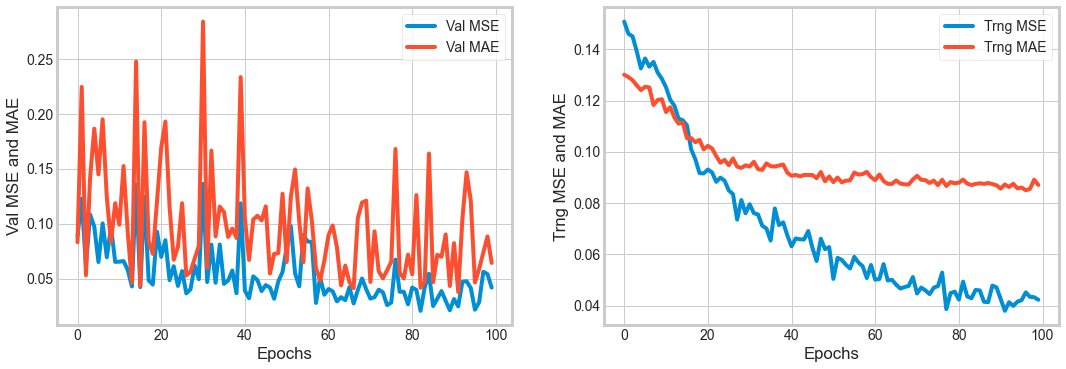

In [120]:
fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax1.plot(hist['val_mse'],label='Val MSE')
ax1.plot(hist['val_mae'],label='Val MAE')
ax1.legend()
ax1.set_ylabel("Val MSE and MAE")
ax1.set_xlabel("Epochs")
ax2.plot(hist['mse'], label='Trng MSE')
ax2.plot(hist['mae'],label='Trng MAE')
ax2.set_ylabel("Trng MSE and MAE")
ax2.set_xlabel("Epochs")
ax2.legend()
plt.show()

### Now we can use this model to make predictions on the test data

In [122]:
test_predictions = model.predict(test_df).flatten()

In [123]:
test_predictions

array([-0.15154028, -0.2578349 , -0.21477127, ..., -0.17163467,
       -0.01337576, -0.15213442], dtype=float32)

### Next, let's plot the test labels (true values) vs test predictions (predicted values). If our model performed well, they should lie pretty close to each other

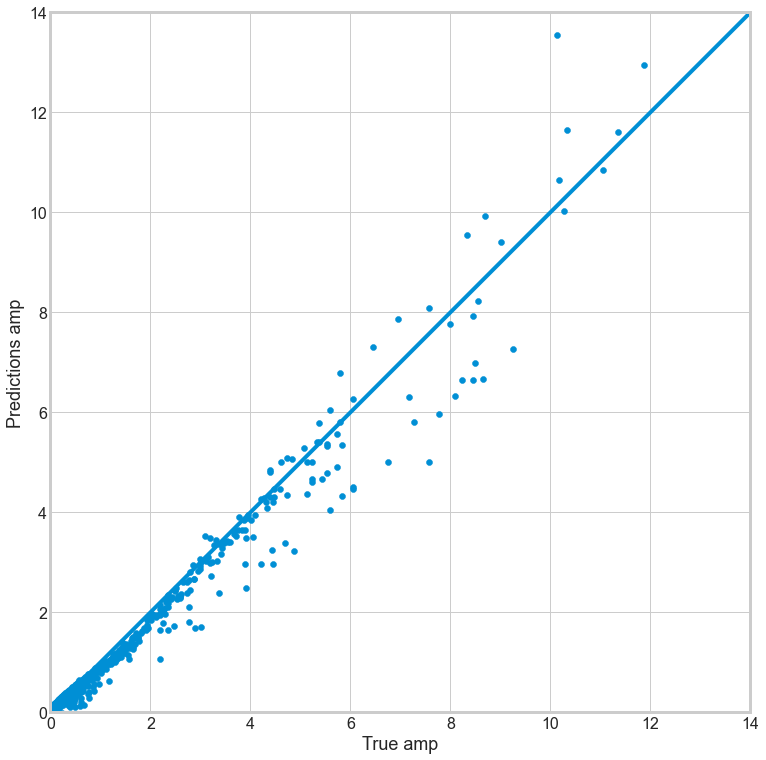

In [124]:
plt.figure(figsize=(12,12))
a = plt.axes(aspect='equal')
plt.scatter(test_label, test_predictions)
plt.xlabel('True amp',fontsize=18)
plt.ylabel('Predictions amp',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
lims = [0, 14]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

### We see that for low values of amplitude, the values match pretty good. For higher values, there is some mismatch between the true values and the predicted values

### In this notebook, we used TensorFlow regression to predict the Amplitude of noise transients from their Signal to Noise ratio and frequency.